In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt

from time import sleep
from skimage.draw import line
from coppeliasim_zmqremoteapi_client import RemoteAPIClient

In [2]:
warnings.filterwarnings('ignore')

client = RemoteAPIClient()
sim = client.require('sim')

# Basic Functions

In [3]:
def Rz(theta):
    return np.array([[ np.cos(theta), -np.sin(theta), 0 ],
                     [ np.sin(theta), np.cos(theta) , 0 ],
                     [ 0            , 0             , 1 ]])

In [4]:
def buildHomogeneousMatrix(rotationMatrix:np.ndarray, translationMatrix:np.ndarray) -> np.ndarray:
    """
    Função destinada a montar a matriz de tranformação homogenea
    :param rotationMatrix: matriz de rotação
    :param translationMatrix: matriz de translação
    :return: retorna a matriz de transformação homogênea
    """
    upperRows = np.concatenate([rotationMatrix, translationMatrix], axis = 1)
    lowerRow = np.array([[0, 0, 0, 1]])
    
    return np.concatenate([upperRows, lowerRow], axis = 0)

def transform(robotPosition:np.ndarray, robotOrientation:np.ndarray, objectPosition:np.ndarray) -> np.ndarray:
    """
    Função destinada a realizar a transformação de um ponto para o referencial do robô
    :param robotPosition: vetor de posição do robô
    :param robotOrientation: vetor de orientação do robô
    :param objectPosition: vetor de posição do objeto
    :return: vetor de posição do objeto sobre o referecial do robô
    """
    rotation = Rz(robotOrientation[2]).T
    translation = rotation @ -robotPosition.T

    homoMatrix = buildHomogeneousMatrix(rotation, translation)
    objectPosition = np.concatenate([objectPosition, np.array([[1]])], axis = 1)

    return homoMatrix @ objectPosition.T

def reverseTransform(robotPosition:np.ndarray, robotOrientation:np.ndarray, objectPosition:np.ndarray) -> np.ndarray:
    """
    Função destinada a realizar a transformação de um ponto para o referencial do robô
    :param robotPosition: vetor de posição do robô
    :param robotOrientation: vetor de orientação do robô
    :param objectPosition: vetor de posição do objeto
    :return: vetor de posição do objeto sobre o referecial do robô
    """
    rotation = Rz(robotOrientation[2])
    translation = robotPosition.T

    homoMatrix = buildHomogeneousMatrix(rotation, translation)
    objectPosition = np.concatenate([objectPosition, np.array([[1]])], axis = 1)

    return homoMatrix @ objectPosition.T

def readSensorData(range_data_signal_id="hokuyo_range_data", 
                    angle_data_signal_id="hokuyo_angle_data"):

    # the first call should be non-blocking to avoid getting out-of-sync angle data
    string_range_data = sim.getStringSignal(range_data_signal_id)
    string_angle_data = sim.getStringSignal(angle_data_signal_id)

    # check the if both data were obtained correctly
    if string_range_data and string_angle_data :
        # unpack data from range and sensor messages
        raw_range_data = np.array(sim.unpackFloatTable(string_range_data))
        raw_angle_data = np.array(sim.unpackFloatTable(string_angle_data))

        return raw_range_data, raw_angle_data

    # return none in case were nothing was gotten from the simulator
    return None, None

def transformSensorData(dist:float, angle:float) -> tuple:
    """
    Função destinada a transformar os dados retornados pelo sensor para coordenadas X, Y
    :param dist: distância do objeto para o robô
    :param angle: angûlo do objeto em relação ao robô
    :return: as coordenadas X, Y de um objeto segundo o referencial do robô
    """
    x = dist * np.cos(angle)
    y = dist * np.sin(angle)
    return x, y

# Controle

In [5]:
def calcNonHolonomicVelocity(fx:float, fy:float, theta:float, 
                             maxv:float = 1, maxw:float = np.deg2rad(45),
                             kr:float = 1, kt:float = 2) -> tuple:
    """
    Função destinada a calcular as velocidades que serão aplicadas sobre o robo
    :param fx: força aplica sobre o eixo X
    :param fy: força aplica sobre o eixo Y
    :param theta: rotação do robo em radianos
    :param maxv: velocidade máxima que desejamos empregar ao robo
    :param maxw: ângulo máximo que desejamos ser capaz de rotacionar o robo
    :param kr: constante aplicada ao cálculo da velociade
    :param kt: constante aplicada ao cálculo da rotação
    :return: velocidade linear e angular
    """
    v = kr*(fx*np.cos(theta) + fy*np.sin(theta))
    w = kt*(np.arctan2(fy,fx) - theta)

    # Limit v,w to +/- max
    v = max(min(v, maxv), -maxv)
    w = max(min(w, maxw), -maxw)        
    
    return v, w

def moveNonHolonomicWheels(leftWheel:int, rightWheel:int, v:float, w:float, L:float, r:float) -> None:
    """
    Função destinada a mover as rodas do robo 
    :param rightWheel: handle para o motor da roda direita
    :param leftWheel: handle para o motor da roda esquerda
    :param v: velocidade linear
    :param w: velocidade angular
    :param L: largura do eixo (em metros)
    :param r: raio roda (em metros)
    :return: None
    """
    vl = ((2.0*v) - (w*L))/(2.0*r)
    vr = ((2.0*v) + (w*L))/(2.0*r)
        
    sim.setJointTargetVelocity(leftWheel, vl)
    sim.setJointTargetVelocity(rightWheel, vr)

def stopNonHolonomicWheels(leftWheel:int, rightWheel:int) -> None:
    """
    Função destinada a para o robo
    :param: None
    :return: None
    """
    sim.setJointTargetVelocity(leftWheel, 0)
    sim.setJointTargetVelocity(rightWheel, 0)

def nonHolonomicControl(fx:float, fy:float, theta:float, leftWheel:int, rightWheel:int) -> None:
    """
    Função destinada a levar o robo até certa posição
    :param fx: força aplica sobre o eixo X
    :param fy: força aplica sobre o eixo Y
    :param theta: rotação do robo em radianos
    :param leftWheel: handle para o motor da roda esquerda
    :param rightWheel: handle para o motor da roda direita
    :return: None
    """
    # Específico do robô
    L = 0.230
    r = 0.035
    
    # move o robô
    v, w = calcNonHolonomicVelocity(fx, fy, theta)
    moveNonHolonomicWheels(leftWheel, rightWheel, v, w, L, r)

In [6]:
def save_laser_data(robot:int):
    # Salva posição e direção do robo
    robotPos = np.array([sim.getObjectPosition(robot)])
    refObjOrient = sim.getObjectOrientation(robot)
    robot_position_collection.append(robotPos)
    robot_rotation_collection.append(refObjOrient)

    # Fazendo leitura do laser   
    raw_range_data, raw_angle_data = readSensorData()
    laser_data = np.array([raw_angle_data, raw_range_data]).T
    laser_data_collection.append(laser_data)

def incremental_plot(
    laser_data_collection,
    robot_position_collection,
    robot_rotation_collection
) :
    fig = plt.figure(figsize=(6,6), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')

    # Plota posição do robo
    robotPos = robot_position_collection[0]
    ax.plot(robotPos[0][0], robotPos[0][1], 'o', color='black')

    for j in range(len(laser_data_collection)):
        laser_data = laser_data_collection[j]
    
        for i in range(len(laser_data)):
            ang, dist = laser_data[i]
            
            # Quando o feixe não acerta nada, retorna o valor máximo (definido na simulação)
            # Logo, usar um pequeno limiar do máximo para considerar a leitura
            if (5 - dist) > 0.1:
                x = dist * np.cos(ang)
                y = dist * np.sin(ang)
    
                pb = np.array([x, y, 0, 1])
    
                robotRefPos = robot_position_collection[j]
                pa_borg = np.array([robotRefPos[0][0], robotRefPos[0][1], 0])  
    
                refObjOrient = robot_rotation_collection[j]
                Rab = Rz(refObjOrient[2])
                
                # Concatena o vetor origem ao final (coluna)
                Tab = np.column_stack((Rab, pa_borg))
                
                # Concatena o vetor auxiliar embaixo (linha)
                aux = np.array([0, 0, 0, 1])
                Tab = np.row_stack((Tab, aux))
                
                pa =  Tab @ pb
                ax.plot(pa[0], pa[1], 'o', color='b')

    ax.grid()
    ax.set_xlim([-5, 5])
    ax.set_ylim([-5, 5])  

# Occupancy Grid

In [7]:
def createGrid(real_life_size:float, cell_size:float) -> np.ndarray:
    """
    Função destinada a criar o grid que usaremos
    :param real_life_size: tamanho em metros que nosso ambiente tem na vida real 
    :param cell_size: tamanho em metros de cada célula
    :return: grid que usaremos
    """
    n_cells = int(real_life_size/cell_size)
    return np.full((n_cells, n_cells), 0.5)

def find_laser_cells(robot_config:np.ndarray, range_:float, angle:float, cell_size:float) -> tuple:
    """
    Função destinada a achar uma correspondência entre a leitura do laser com uma célula do grid
    :param robot_config: array de configuração do robo
    :param range_: distância medida por cada laser
    :param angle: inclinação de cada laser em Z, em radianos
    :param cell_size: tamanho da célula em metros
    :return: tupla que indica a célula equivalente
    """
    x = robot_config[0]
    y = robot_config[1]
    theta = robot_config[2]

    x_o = range_ * np.cos(angle + theta) + x
    y_o = - range_ * np.sin(angle + theta) + y

    x_o = int(np.floor(x_o / cell_size))
    y_o = int(np.floor(y_o / cell_size))

    return x_o, y_o

def prob_to_log_odds(prob:float) -> float:
    """
    Função destinada a calcular a log-odds a partir da probabilidade
    :param prob: a probabilidade de daquela célula dado as
                leituras e que o robo navegou por estados                
    :return: a log-odds 
    """
    return np.log(prob/(1 - prob))

def log_odds_to_prob(log_odd:float) -> float:
    """
    Função destinada a calcular a probabilidade a partir da log-odds
    :return log_odd: a log-odds     
    :return: a probabilidade de daquela célula dado as
            leituras e que o robo navegou por estados                
    """
    return 1 - 1/(1 + np.exp(log_odd))

In [8]:
L_FREE = prob_to_log_odds(0.1)
L_OCC = prob_to_log_odds(0.9)

def occupancy_grid_mapping(grid:np.ndarray, robot_config:np.ndarray, range_:float, angle:float, cell_size:float) -> None:
    """
    Função destinada a atualizar o grid com novas medições
    :param grid: grid da representação do mapa
    :param robot_config: array de configuração do robo
    :param range_: distância medida por cada laser
    :param angle: inclinação de cada laser em Z, em radianos
    :param cell_size: tamanho da célula em metros
    :return: None
    """
    x_laser, y_laser = find_laser_cells(robot_config, range_, angle, cell_size)
    x_robot, y_robot = np.floor(robot_config[:2] / cell_size)
    x_robot, y_robot = int(x_robot), int(y_robot)

    xx, yy = line(x_robot, y_robot, x_laser, y_laser)

    hit = (5 - range_) > 0.1

    for x, y in zip(xx, yy):
        prob = grid[x, y]
        l_ant = prob_to_log_odds(prob)
        l_t = l_ant + inverse_range_sensor_model(x, y, x_laser, y_laser, hit)
        grid[x, y] = log_odds_to_prob(l_t)

def inverse_range_sensor_model(x:int, y:int, x_laser:int, y_laser:int, hit:bool = True) -> float:
    """
    Função destinada a c
    :param x: o x de uma célula atravesada pelo laser
    :param y: o y de uma célula atravesada pelo laser
    :param x_laser: o x da última célula atingida pelo laser
    :param y_laser: o y da última célula atingida pelo laser
    :param hit: caso o laser tenha captado algo, até o final
    :return: a log-odds equivalente
    """
    if (x != x_laser or y != y_laser) or not hit:
        return L_FREE
    
    if x == x_laser and y == y_laser and hit:
        return L_OCC

def update_probabilities(grid:np.ndarray, robot_config:np.ndarray, ranges:np.ndarray, angles:np.ndarray, cell_size:float) -> None:
    """
    Função destinada a atualizar as probabilidade do grid de acordo com as leituras
    :param grid: grid da representação do mapa
    :param robot_config: array de configuração do robo
    :param ranges: array de distâncias medidas por cada laser
    :param angles: array de inclinação de cada laser em Z, em radianos
    :param cell_size: tamanho da célula em metros
    :return: None
    """
    for range_, angle in zip(ranges, angles):
        occupancy_grid_mapping(grid, robot_config, range_, angle, cell_size)

In [9]:
def plot_grid(grid:np.ndarray) -> None:
    """
    Função destinada a plotar o occupancy grid
    :param grid: grid que representa o mapa
    :return: None
    """
    plt.imshow(grid, cmap='Greys', origin='upper')
    plt.axis('off')
    plt.colorbar()

In [10]:
log_odds_to_prob(prob_to_log_odds(.2) * 4)

0.0038910505836575737

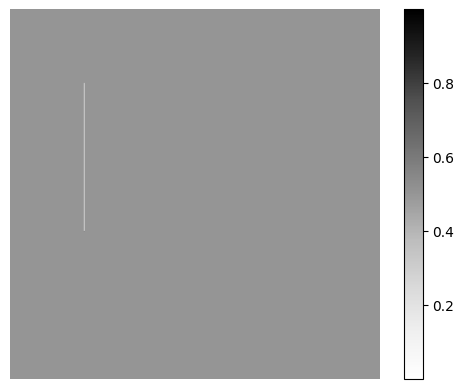

In [11]:
grid = createGrid(10, 0.01)
for _ in range(10):
    update_probabilities(grid, np.array([2, 2, 0]), [4], [0], 0.01)
plot_grid(grid)

In [7]:
robotname = '/kobuki'
robot = sim.getObject(f"{robotname}")
leftWheel  = sim.getObject(f"{robotname}/wheel_left_drop_sensor/wheel_left_drop_respondable/kobuki_leftMotor")
rightWheel = sim.getObject(f"{robotname}/wheel_right_drop_sensor/wheel_right_drop_respondable/kobuki_rightMotor")

In [16]:
sim.startSimulation()
sleep(1)
range, angle = readSensorData()
sim.stopSimulation()

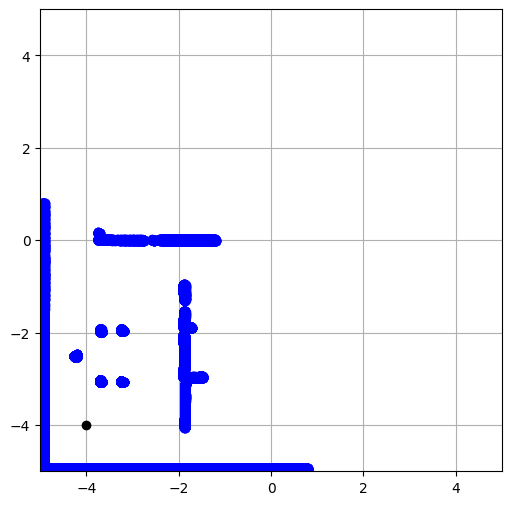

In [8]:
sim.startSimulation()
theta = sim.getObjectOrientation(robot)[-2]

laser_data_collection = []
robot_position_collection = []
robot_rotation_collection = []

rotateRobot(robot, leftWheel, rightWheel, theta)

sim.stopSimulation()

incremental_plot(
    laser_data_collection,
    robot_position_collection,
    robot_rotation_collection
)